In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import pickle
import datetime

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Flatten,MaxPool2D,BatchNormalization,GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.VGG16 import VGG16
#from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import load_model

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/CS331-BÁO CÁO"
TRAIN_PATH = os.path.join(ROOT_DIR, 'flowers_splited/train')
TEST_PATH = os.path.join(ROOT_DIR, 'flowers_splited/test')

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
target_size = (img_height, img_width)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        color_mode='rgb',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', 
    color_mode='rgb',
    subset='validation') 


test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        color_mode='rgb',
        shuffle=False)

Found 3107 images belonging to 5 classes.
Found 775 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [ ]:
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       

class_weights = []
for class_id, num_images in counter.items():
    class_weights.append({class_id : max_val/num_images})
    print(class_id, num_images)                  
class_weights

0 550
1 757
2 564
3 528
4 708


[{0: 1.3763636363636365},
 {1: 1.0},
 {2: 1.3421985815602837},
 {3: 1.433712121212121},
 {4: 1.0692090395480225}]

#**PHẦN DEMO**

**RESNET50**

In [ ]:
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))

#for layer in base_model.layers[:(len(base_model.layers) // 3 * 2)]:
#   layer.trainable = False

for i, layer in enumerate(base_model.layers):
    print(i, layer.name, "-", layer.trainable)

94765736/94765736 [==============================] - 3s 0us/step
0 input_1 - True
1 conv1_pad - True
2 conv1_conv - True
3 conv1_bn - True
4 conv1_relu - True
5 pool1_pad - True
6 pool1_pool - True
7 conv2_block1_1_conv - True
8 conv2_block1_1_bn - True
9 conv2_block1_1_relu - True
10 conv2_block1_2_conv - True
11 conv2_block1_2_bn - True
12 conv2_block1_2_relu - True
13 conv2_block1_0_conv - True
14 conv2_block1_3_conv - True
15 conv2_block1_0_bn - True
16 conv2_block1_3_bn - True
17 conv2_block1_add - True
18 conv2_block1_out - True
19 conv2_block2_1_conv - True
20 conv2_block2_1_bn - True
21 conv2_block2_1_relu - True
22 conv2_block2_2_conv - True
23 conv2_block2_2_bn - True
24 conv2_block2_2_relu - True
25 conv2_block2_3_conv - True
26 conv2_block2_3_bn - True
27 conv2_block2_add - True
28 conv2_block2_out - True
29 conv2_block3_1_conv - True
30 conv2_block3_1_bn - True
31 conv2_block3_1_relu - True
32 conv2_block3_2_conv - True
33 conv2_block3_2_bn - True
34 conv2_block3_2_relu - 

In [ ]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [ ]:
best_model = model
best_model.load_weights('/content/drive/MyDrive/CS331-BÁO CÁO/weights_model/ResNet50.h5')

In [ ]:
class_names = train_generator.class_indices
print(class_names)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import load_img, img_to_array

In [ ]:
def demo(IMG_PATH):
   # img_show = cv2.imread(IMG_PATH)
    #cv2_imshow(img_show)

    img = load_img(IMG_PATH,target_size= (224,224))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
    img = img_to_array(img)
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    pred_datagen = ImageDataGenerator(rescale=1. / 255)
    pred_gen = pred_datagen.flow(img, batch_size=1)
    pred = best_model.predict(pred_gen)[0]

    class_names_list = list(class_names.keys())
    class_names_values_list = list(class_names.values())
    #print(class_names_list)
    #print(class_names_values_list)
    print("The predicted class is: ", class_names_list[class_names_values_list.index(np.argmax(pred))])

    for i in range(len(class_names_list)):
        print('{}: {}%'.format(class_names_list[i], f'{pred[i] * 100:.2f}'))
    

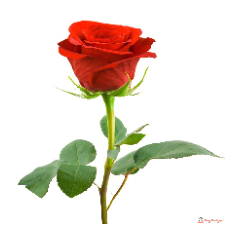

1/1 [==============================] - 8s 8s/step
The predicted class is:  rose
daisy: 0.19%
dandelion: 0.01%
rose: 66.36%
sunflower: 0.10%
tulip: 33.34%


In [ ]:
IMG_PATH = '/content/drive/MyDrive/CS331-BÁO CÁO/test1.jpg'
demo(IMG_PATH)

**EFFICIENTNETB2**

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB2

In [ ]:
base_model1 = EfficientNetB2(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))



for i, layer in enumerate(base_model1.layers):
    print(i, layer.name, "-", layer.trainable)

31790344/31790344 [==============================] - 1s 0us/step
0 input_2 - True
1 rescaling - True
2 normalization - True
3 tf.math.truediv - True
4 stem_conv_pad - True
5 stem_conv - True
6 stem_bn - True
7 stem_activation - True
8 block1a_dwconv - True
9 block1a_bn - True
10 block1a_activation - True
11 block1a_se_squeeze - True
12 block1a_se_reshape - True
13 block1a_se_reduce - True
14 block1a_se_expand - True
15 block1a_se_excite - True
16 block1a_project_conv - True
17 block1a_project_bn - True
18 block1b_dwconv - True
19 block1b_bn - True
20 block1b_activation - True
21 block1b_se_squeeze - True
22 block1b_se_reshape - True
23 block1b_se_reduce - True
24 block1b_se_expand - True
25 block1b_se_excite - True
26 block1b_project_conv - True
27 block1b_project_bn - True
28 block1b_drop - True
29 block1b_add - True
30 block2a_expand_conv - True
31 block2a_expand_bn - True
32 block2a_expand_activation - True
33 block2a_dwconv_pad - True
34 block2a_dwconv - True
35 block2a_bn - True
3

In [ ]:
model1 = tf.keras.Sequential([
    base_model1, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               180352    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [ ]:
best_model1 = model1
best_model1.load_weights('/content/drive/MyDrive/CS331-BÁO CÁO/weights_model/EFF2.h5')

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from keras.utils import load_img, img_to_array

In [ ]:
def demo1(IMG_PATH):
   # img_show = cv2.imread(IMG_PATH)
    #cv2_imshow(img_show)

    img = load_img(IMG_PATH,target_size= (224,224))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
    img = img_to_array(img)
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    pred_datagen = ImageDataGenerator(rescale=1. / 255)
    pred_gen = pred_datagen.flow(img, batch_size=1)
    pred = best_model1.predict(pred_gen)[0]

    class_names_list = list(class_names.keys())
    class_names_values_list = list(class_names.values())
    #print(class_names_list)
    #print(class_names_values_list)
    print("The predicted class is: ", class_names_list[class_names_values_list.index(np.argmax(pred))])

    for i in range(len(class_names_list)):
        print('{}: {}%'.format(class_names_list[i], f'{pred[i] * 100:.2f}'))
    

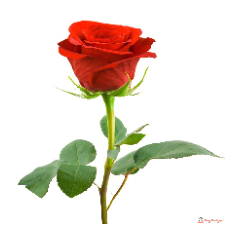

1/1 [==============================] - 3s 3s/step
The predicted class is:  rose
daisy: 0.00%
dandelion: 0.00%
rose: 99.56%
sunflower: 0.42%
tulip: 0.02%


In [ ]:
IMG_PATH = '/content/drive/MyDrive/CS331-BÁO CÁO/test1.jpg'
demo1(IMG_PATH)

**EFFCIENTNETB0**


In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

In [ ]:
base_model2 = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))


for i, layer in enumerate(base_model2.layers):
    print(i, layer.name, "-", layer.trainable)

16705208/16705208 [==============================] - 1s 0us/step
0 input_3 - True
1 rescaling_1 - True
2 normalization_1 - True
3 tf.math.truediv_1 - True
4 stem_conv_pad - True
5 stem_conv - True
6 stem_bn - True
7 stem_activation - True
8 block1a_dwconv - True
9 block1a_bn - True
10 block1a_activation - True
11 block1a_se_squeeze - True
12 block1a_se_reshape - True
13 block1a_se_reduce - True
14 block1a_se_expand - True
15 block1a_se_excite - True
16 block1a_project_conv - True
17 block1a_project_bn - True
18 block2a_expand_conv - True
19 block2a_expand_bn - True
20 block2a_expand_activation - True
21 block2a_dwconv_pad - True
22 block2a_dwconv - True
23 block2a_bn - True
24 block2a_activation - True
25 block2a_se_squeeze - True
26 block2a_se_reshape - True
27 block2a_se_reduce - True
28 block2a_se_expand - True
29 block2a_se_excite - True
30 block2a_project_conv - True
31 block2a_project_bn - True
32 block2b_expand_conv - True
33 block2b_expand_bn - True
34 block2b_expand_activation

In [ ]:
model2 = tf.keras.Sequential([
    base_model2, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [ ]:
best_model2 = model2
best_model2.load_weights('/content/drive/MyDrive/CS331-BÁO CÁO/weights_model/effcientnetB0.h5')

In [ ]:
def demo2(IMG_PATH):
   # img_show = cv2.imread(IMG_PATH)
    #cv2_imshow(img_show)

    img = load_img(IMG_PATH,target_size= (224,224))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
    img = img_to_array(img)
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    pred_datagen = ImageDataGenerator(rescale=1. / 255)
    pred_gen = pred_datagen.flow(img, batch_size=1)
    pred = best_model2.predict(pred_gen)[0]

    class_names_list = list(class_names.keys())
    class_names_values_list = list(class_names.values())
    #print(class_names_list)
    #print(class_names_values_list)
    print("The predicted class is: ", class_names_list[class_names_values_list.index(np.argmax(pred))])

    for i in range(len(class_names_list)):
        print('{}: {}%'.format(class_names_list[i], f'{pred[i] * 100:.2f}'))
    

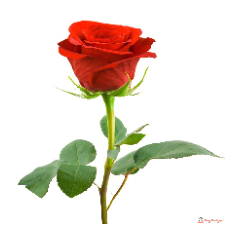

1/1 [==============================] - 2s 2s/step
The predicted class is:  rose
daisy: 0.00%
dandelion: 0.03%
rose: 99.38%
sunflower: 0.15%
tulip: 0.44%


In [ ]:
IMG_PATH = '/content/drive/MyDrive/CS331-BÁO CÁO/test1.jpg'
demo2(IMG_PATH)

**MOBINETV2**

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
base_model3 = MobileNetV2(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))



for i, layer in enumerate(base_model3.layers):
    print(i, layer.name, "-", layer.trainable)

9406464/9406464 [==============================] - 0s 0us/step
0 input_4 - True
1 Conv1 - True
2 bn_Conv1 - True
3 Conv1_relu - True
4 expanded_conv_depthwise - True
5 expanded_conv_depthwise_BN - True
6 expanded_conv_depthwise_relu - True
7 expanded_conv_project - True
8 expanded_conv_project_BN - True
9 block_1_expand - True
10 block_1_expand_BN - True
11 block_1_expand_relu - True
12 block_1_pad - True
13 block_1_depthwise - True
14 block_1_depthwise_BN - True
15 block_1_depthwise_relu - True
16 block_1_project - True
17 block_1_project_BN - True
18 block_2_expand - True
19 block_2_expand_BN - True
20 block_2_expand_relu - True
21 block_2_depthwise - True
22 block_2_depthwise_BN - True
23 block_2_depthwise_relu - True
24 block_2_project - True
25 block_2_project_BN - True
26 block_2_add - True
27 block_3_expand - True
28 block_3_expand_BN - True
29 block_3_expand_relu - True
30 block_3_pad - True
31 block_3_depthwise - True
32 block_3_depthwise_BN - True
33 block_3_depthwise_relu - 

In [ ]:
model3 = tf.keras.Sequential([
    base_model3, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

In [ ]:
best_model3 = model3
best_model3.load_weights('/content/drive/MyDrive/CS331-BÁO CÁO/weights_model/mobinetv2.h5')

In [ ]:
def demo3(IMG_PATH):
   # img_show = cv2.imread(IMG_PATH)
    #cv2_imshow(img_show)

    img = load_img(IMG_PATH,target_size= (224,224))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
    img = img_to_array(img)
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    pred_datagen = ImageDataGenerator(rescale=1. / 255)
    pred_gen = pred_datagen.flow(img, batch_size=1)
    pred = best_model3.predict(pred_gen)[0]

    class_names_list = list(class_names.keys())
    class_names_values_list = list(class_names.values())
    #print(class_names_list)
    #print(class_names_values_list)
    print("The predicted class is: ", class_names_list[class_names_values_list.index(np.argmax(pred))])

    for i in range(len(class_names_list)):
        print('{}: {}%'.format(class_names_list[i], f'{pred[i] * 100:.2f}'))
    

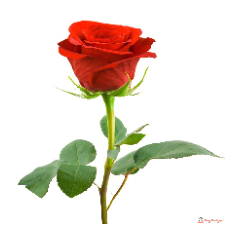

1/1 [==============================] - 1s 980ms/step
The predicted class is:  rose
daisy: 0.00%
dandelion: 0.02%
rose: 74.57%
sunflower: 1.77%
tulip: 23.65%


In [ ]:
IMG_PATH = '/content/drive/MyDrive/CS331-BÁO CÁO/test1.jpg'
demo3(IMG_PATH)

#**PHẦN SO SÁNH MODEL**

In [ ]:
pickle_in = open(os.path.join(ROOT_DIR, '50epochs_history_dict_effcientnetB0.pkl'), "rb")
dict_log = pickle.load(pickle_in)
#/content/drive/MyDrive/CS331-BÁO CÁO/Code/50epochs_history_dict_effcientnetB0.pkl

In [ ]:
pickle_in1 = open(os.path.join(ROOT_DIR, 'history_dict_effb2.pkl'), "rb")
dict_log1 = pickle.load(pickle_in1)

In [ ]:
pickle_in2 = open(os.path.join(ROOT_DIR, 'history_dict_mobinetv2.pkl'), "rb")
dict_log2 = pickle.load(pickle_in2)

In [ ]:
pickle_in3 = open(os.path.join(ROOT_DIR, 'history_dict_ResNet50.pkl'), "rb")
dict_log3 = pickle.load(pickle_in3)

In [ ]:
dict_log.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

**SO SÁNH ACCURACY**

(0.6, 1.0)

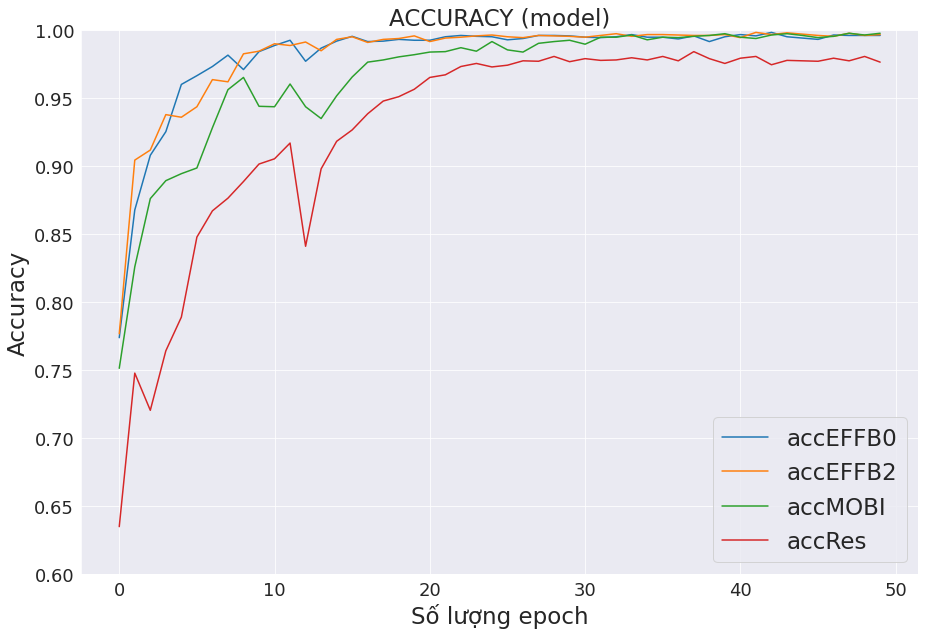

In [ ]:
plt.figure(figsize=(15, 10))
# plt.grid()


plt.plot(dict_log['accuracy'], label='accEFFB0')
plt.plot(dict_log1['accuracy'], label='accEFFB2')
plt.plot(dict_log2['accuracy'], label ='accMOBI')
plt.plot(dict_log3['accuracy'],label='accRes')

plt.title('ACCURACY (model)', fontsize=23)
plt.ylabel('Accuracy', fontsize=23)
plt.xlabel('Số lượng epoch', fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.legend(['train', 'validation'], loc="upper left")

plt.legend(loc=0, numpoints=1, fontsize=23, ncol=1)
plt.ylim(0.6, 1)

# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-1.png")


**SO SÁNH LOSS**

(0.0, 1.0)

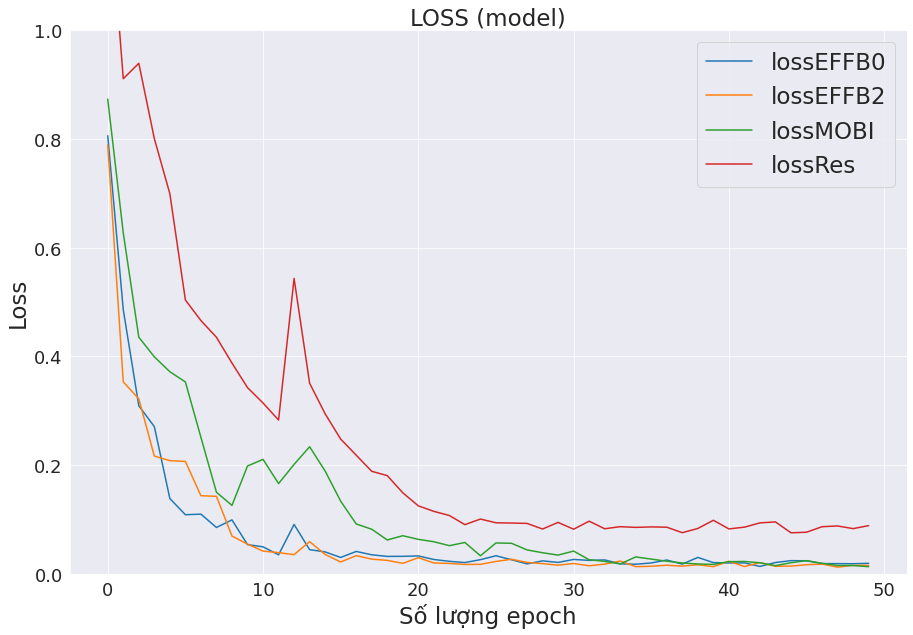

In [ ]:
plt.figure(figsize=(15, 10))
# plt.grid()


plt.plot(dict_log['loss'], label='lossEFFB0')
plt.plot(dict_log1['loss'], label='lossEFFB2')
plt.plot(dict_log2['loss'], label ='lossMOBI')
plt.plot(dict_log3['loss'],label='lossRes')

plt.title('LOSS (model)', fontsize=23)
plt.ylabel('Loss', fontsize=23)
plt.xlabel('Số lượng epoch', fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.legend(['train', 'validation'], loc="upper left")

plt.legend(loc=0, numpoints=1, fontsize=23, ncol=1)
plt.ylim(0, 1)

# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-1.png")


**SO SÁNH Val_ACC**

(0.0, 1.0)

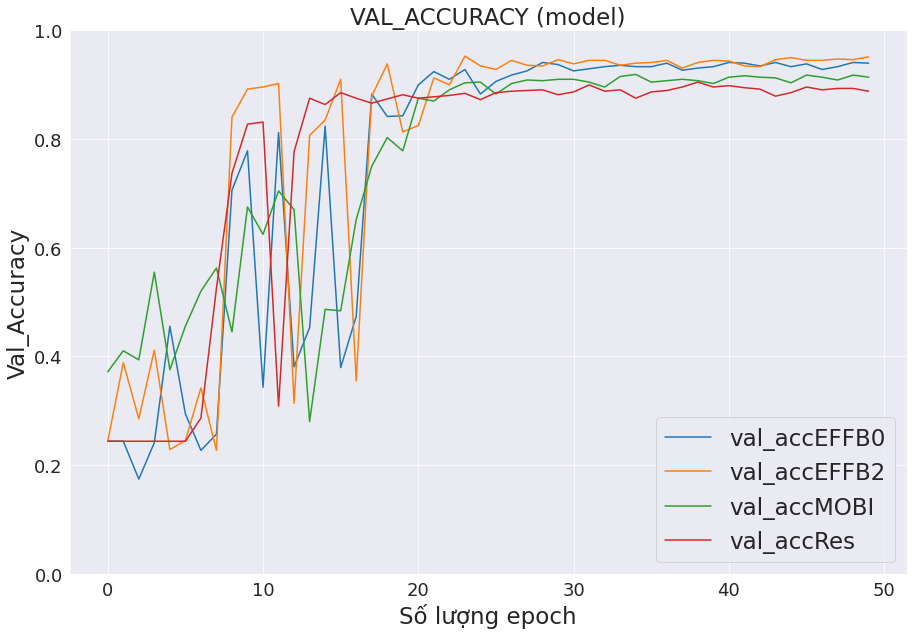

In [ ]:
plt.figure(figsize=(15, 10))
# plt.grid()


plt.plot(dict_log['val_accuracy'], label='val_accEFFB0')
plt.plot(dict_log1['val_accuracy'], label='val_accEFFB2')
plt.plot(dict_log2['val_accuracy'], label ='val_accMOBI')
plt.plot(dict_log3['val_accuracy'],label='val_accRes')

plt.title('VAL_ACCURACY (model)', fontsize=23)
plt.ylabel('Val_Accuracy', fontsize=23)
plt.xlabel('Số lượng epoch', fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.legend(['train', 'validation'], loc="upper left")

plt.legend(loc=0, numpoints=1, fontsize=23, ncol=1)
plt.ylim(0, 1)

# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-1.png")


**SO SÁNH VAL_LOSS**

(0.0, 1.0)

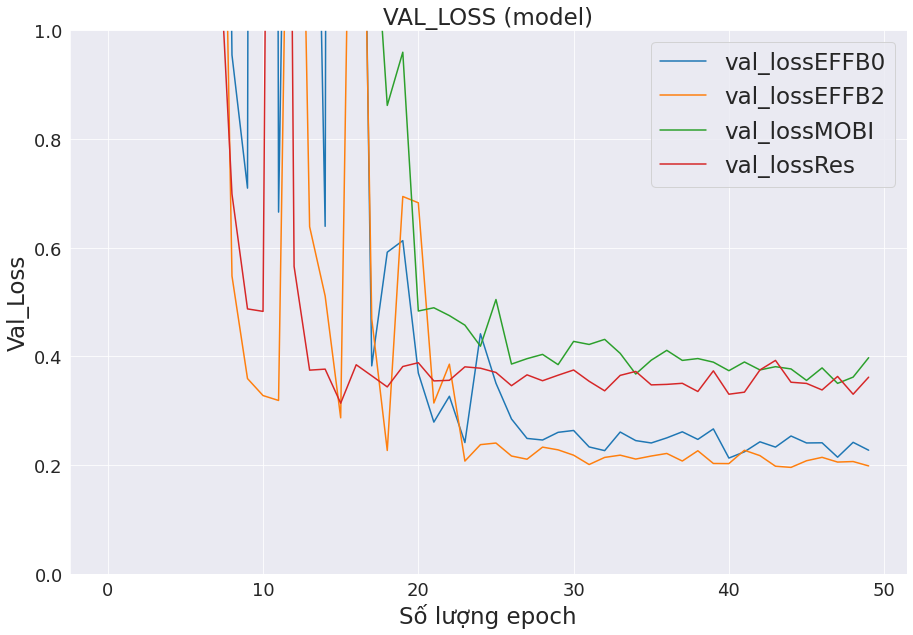

In [ ]:
plt.figure(figsize=(15, 10))
# plt.grid()


plt.plot(dict_log['val_loss'], label='val_lossEFFB0')
plt.plot(dict_log1['val_loss'], label='val_lossEFFB2')
plt.plot(dict_log2['val_loss'], label ='val_lossMOBI')
plt.plot(dict_log3['val_loss'],label='val_lossRes')

plt.title('VAL_LOSS (model)', fontsize=23)
plt.ylabel('Val_Loss', fontsize=23)
plt.xlabel('Số lượng epoch', fontsize=23)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.legend(['train', 'validation'], loc="upper left")

plt.legend(loc=0, numpoints=1, fontsize=23, ncol=1)
plt.ylim(0, 1)

# plt.savefig("/content/drive/MyDrive/COURSES/CS231/results/vgg19-1.png")
